# **CNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [35]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/NotAveragePooled/split_features_2s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [36]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [37]:
train_data

{'melspectrogram': array([[[2.70414866e-03, 2.79165306e-04, 2.78151976e-06, ...,
          5.40252245e-16, 1.56153176e-05, 1.55124408e-04],
         [2.85087147e-03, 2.95306839e-04, 3.42857310e-06, ...,
          1.44704444e-15, 1.58973962e-05, 1.57929313e-04],
         [3.04498922e-03, 3.15533762e-04, 4.71718391e-06, ...,
          3.38392743e-15, 1.63767277e-05, 1.62701248e-04],
         ...,
         [4.71950382e-06, 6.96979924e-07, 9.83989841e-06, ...,
          4.08672234e-08, 1.99395944e-05, 1.89381415e-04],
         [4.43196142e-06, 4.70733005e-07, 1.06044568e-07, ...,
          4.94281655e-10, 1.80252409e-05, 1.73290591e-04],
         [4.34125244e-06, 4.54310514e-07, 3.83112779e-09, ...,
          2.21867693e-13, 1.70996799e-05, 1.64420217e-04]],
 
        [[2.21674682e-07, 8.28132378e-09, 1.14113669e-16, ...,
          5.64442031e-13, 4.15756946e-08, 3.75276195e-07],
         [2.63981337e-07, 9.74223593e-09, 2.37362292e-16, ...,
          5.92175932e-13, 4.42072655e-08, 3.9971

In [38]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [39]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [40]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [41]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [42]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [43]:
display(train_y.shape)
display(train_y[:15])

(22631,)

array([16, 18, 16,  8,  0,  7,  1, 13,  5,  0,  0, 10,  0,  3,  0],
      dtype=int32)

In [44]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(22631, 60, 87)

array([[2.51750206e-04, 4.63635016e-05, 3.09758646e-12, ...,
        5.68676796e-13, 3.82335129e-08, 5.15132790e-07],
       [2.60138366e-04, 4.79124536e-05, 4.27148327e-12, ...,
        8.23245387e-13, 1.38072087e-07, 1.71942709e-06],
       [2.74948944e-04, 5.06501715e-05, 1.28938086e-11, ...,
        4.50645997e-12, 3.23376246e-07, 3.95625341e-06],
       ...,
       [1.43458462e-06, 2.64033143e-07, 9.53330979e-09, ...,
        1.02847336e-08, 3.21130295e-08, 2.44415090e-07],
       [1.34675330e-06, 2.40034602e-07, 7.10412014e-11, ...,
        6.88556118e-11, 1.90400122e-08, 2.32998140e-07],
       [1.29980401e-06, 2.31511356e-07, 3.06543286e-14, ...,
        6.60463375e-14, 1.98763233e-08, 2.44531143e-07]])

'mfcc'

(22631, 20, 87)

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [ 2.62704509e-01,  2.37042778e-01,  8.85397043e-02, ...,
         5.07429730e-02,  7.36468915e-02,  1.06933690e-01],
       [-4.13504613e-01, -5.16838038e-01, -6.03458236e-01, ...,
        -5.53121285e-01, -5.40396427e-01, -4.66811516e-01],
       ...,
       [ 5.73555826e-04, -1.71979975e-02, -2.91266243e-02, ...,
        -4.35379640e-03, -1.75837886e-02, -3.30723337e-02],
       [ 1.36677224e-02,  2.73908312e-03, -1.34448437e-02, ...,
         2.26966808e-02,  1.88631682e-02,  1.08559741e-02],
       [-4.26551206e-03, -4.60970839e-03, -2.66997041e-02, ...,
        -1.38243368e-02, -6.66467708e-03, -6.21837050e-03]])

'chroma'

(22631, 12, 87)

array([[0.39349289, 1.        , 0.76565271, ..., 0.42511843, 0.53971734,
        0.87640076],
       [0.40241583, 0.3937928 , 0.25525414, ..., 1.        , 1.        ,
        0.97018468],
       [1.        , 0.50390339, 0.2457685 , ..., 0.80265059, 0.70749506,
        0.72226342],
       ...,
       [0.48373222, 0.35887895, 0.33238306, ..., 0.44334805, 0.30104765,
        0.54676064],
       [0.48656566, 0.43102517, 0.68563702, ..., 0.27053293, 0.23075898,
        0.29046017],
       [0.45659793, 0.77367048, 0.74913608, ..., 0.20811069, 0.18596628,
        0.23210441]])

'rms'

(22631, 1, 87)

array([[0.01566686, 0.01963366, 0.02267696, 0.02198208, 0.0236679 ,
        0.02365906, 0.02739311, 0.02892642, 0.02962335, 0.03161302,
        0.02964298, 0.02855054, 0.02637647, 0.02320143, 0.02127909,
        0.02082221, 0.02107353, 0.02044727, 0.0215389 , 0.02171538,
        0.02103248, 0.02137822, 0.02056518, 0.02047369, 0.02067877,
        0.02130214, 0.02133721, 0.02149762, 0.02284854, 0.02213321,
        0.02208988, 0.02265538, 0.02229255, 0.02197747, 0.02131361,
        0.02166785, 0.02138098, 0.02257396, 0.02174746, 0.02019637,
        0.01945506, 0.01891561, 0.02042461, 0.02097673, 0.02098343,
        0.02131834, 0.0205403 , 0.01974241, 0.02029415, 0.02024212,
        0.02057395, 0.02136144, 0.02033739, 0.02035925, 0.02131695,
        0.02042016, 0.02099958, 0.0204634 , 0.01956393, 0.01958668,
        0.01869692, 0.01864281, 0.01893451, 0.01934329, 0.02076074,
        0.019988  , 0.02005406, 0.01977013, 0.01903823, 0.02036951,
        0.01973328, 0.01997821, 0.01980979, 0.01

In [45]:
display(val_y.shape)
display(val_y[:15])

(6044,)

array([10,  2, 12,  0,  1, 18,  2,  2, 17,  2,  2,  2,  0, 17,  7],
      dtype=int32)

In [46]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(6044, 60, 87)

array([[2.17200396e-04, 4.53335971e-05, 1.29495222e-13, ...,
        1.21034555e-12, 5.17416951e-05, 4.10931854e-04],
       [2.20289099e-04, 4.59743197e-05, 1.15376292e-13, ...,
        2.42292258e-12, 5.26615844e-05, 4.18141088e-04],
       [2.25604917e-04, 4.70761660e-05, 1.25535822e-12, ...,
        5.34527052e-12, 5.42772074e-05, 4.30814610e-04],
       ...,
       [8.90270095e-05, 2.79290157e-05, 9.93993419e-06, ...,
        5.31224018e-06, 8.29869500e-06, 4.28595645e-05],
       [6.43069815e-05, 1.35614011e-05, 7.30470999e-08, ...,
        5.46549170e-08, 3.75281510e-06, 3.03586412e-05],
       [5.72050771e-05, 1.19834535e-05, 5.41687084e-11, ...,
        3.40280461e-11, 3.30304761e-06, 2.68653043e-05]])

'mfcc'

(6044, 20, 87)

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-0.09862846, -0.12620195, -0.12663318, ..., -0.1111495 ,
        -0.1070803 , -0.02270118],
       [-0.29836299, -0.33394759, -0.32964431, ..., -0.3771704 ,
        -0.38720772, -0.31023319],
       ...,
       [-0.01199706, -0.01576515, -0.01627717, ..., -0.01366932,
        -0.00583596, -0.01006811],
       [ 0.01272396,  0.02332593,  0.02962993, ...,  0.02214662,
         0.01887524,  0.01693689],
       [ 0.00693204,  0.00399565, -0.0058478 , ...,  0.00683166,
         0.00928418,  0.01052039]])

'chroma'

(6044, 12, 87)

array([[0.6451998 , 0.64002737, 0.68638929, ..., 0.75993676, 0.63950148,
        0.55819746],
       [0.62599534, 0.62821159, 0.83698962, ..., 0.60072089, 0.6233961 ,
        0.60917188],
       [1.        , 1.        , 1.        , ..., 0.38736675, 0.41141488,
        0.28301741],
       ...,
       [0.296773  , 0.46498901, 0.57427021, ..., 0.64805023, 0.95710992,
        1.        ],
       [0.27340847, 0.37722187, 0.48655279, ..., 0.466577  , 0.80984084,
        0.76830987],
       [0.53433068, 0.48248988, 0.52454861, ..., 0.40279458, 0.54774282,
        0.67895615]])

'rms'

(6044, 1, 87)

array([[0.00496129, 0.0059438 , 0.00697781, 0.00701446, 0.00727218,
        0.00736816, 0.00718243, 0.00729699, 0.0080523 , 0.00894135,
        0.00983361, 0.01031962, 0.01031073, 0.01027326, 0.01062839,
        0.01090027, 0.01210153, 0.01223124, 0.01218716, 0.01219549,
        0.01137712, 0.01163485, 0.01261372, 0.01224262, 0.01199135,
        0.01139301, 0.00976132, 0.01036333, 0.0136469 , 0.0338731 ,
        0.06918351, 0.09940138, 0.13557129, 0.15677701, 0.16202463,
        0.1640733 , 0.16449983, 0.19005741, 0.2260389 , 0.23742491,
        0.22443756, 0.20471627, 0.15242663, 0.11055657, 0.09755287,
        0.04201634, 0.01273967, 0.0110363 , 0.01018296, 0.00948956,
        0.00891118, 0.00858342, 0.0082546 , 0.00820571, 0.00877933,
        0.00884571, 0.00906115, 0.0090993 , 0.00816916, 0.00799693,
        0.00757182, 0.00754186, 0.00973617, 0.01017493, 0.01046399,
        0.0105744 , 0.01057907, 0.01014374, 0.00990268, 0.00985158,
        0.00963962, 0.01019118, 0.01032453, 0.01

## **CNN Model**

In [47]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # add first convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=32,
              kernel_size=3,
              strides=1,
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)

  # add first max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(features)

  # add second convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=64,
              kernel_size=3,
              strides=1,
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

  # add second max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=512,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.2)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [48]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [49]:
train_results = {}
val_results = {}

### **With all the features**

In [50]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(22631, 93, 87)

In [51]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(6044, 93, 87)

Fit the model with training data

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 93, 87)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 93, 32)              │           8,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         754,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 779,028 (2.97 MB)

 Trainable params: 779,028 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2127 - loss: 4.2204 - weighted_accuracy: 0.2127 - val_accuracy: 0.2669 - val_loss: 3.5482 - val_weighted_accuracy: 0.2669
Epoch 2/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3689 - loss: 3.2217 - weighted_accuracy: 0.3689 - val_accuracy: 0.3501 - val_loss: 3.0874 - val_weighted_accuracy: 0.3501
Epoch 3/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4358 - loss: 2.7152 - weighted_accuracy: 0.4358 - val_accuracy: 0.3334 - val_loss: 2.9016 - val_weighted_accuracy: 0.3334
Epoch 4/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4944 - loss: 2.3642 - weighted_accuracy: 0.4944 - val_accuracy: 0.3561 - val_loss: 2.7863 - val_weighted_accuracy: 0.3561
Epoch 5/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5292 - loss: 2.1268 - weighted_accuracy: 0.5292 - val_accuracy: 0.3703 - val_loss: 2.7286 - val_weighted_accuracy: 0.3703
Epoch 6/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - a

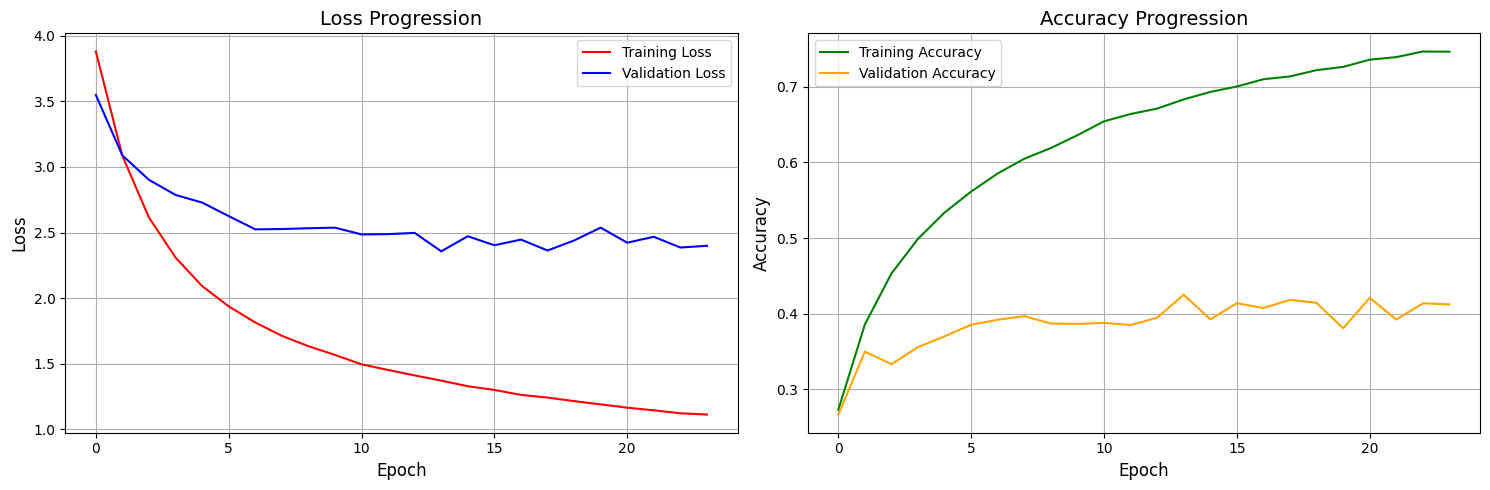

In [52]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [53]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7187 - loss: 1.2856 - weighted_accuracy: 0.7187
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4315 - loss: 2.3365 - weighted_accuracy: 0.4315


## **With MFCCs and Mel-Spectrogram**

In [54]:
training_features = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)

training_features.shape

(22631, 80, 87)

In [55]:
validation_features = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)

validation_features.shape

(6044, 80, 87)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 80, 87)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 80, 32)              │           8,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 40, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 40, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 680,724 (2.60 MB)

 Trainable params: 680,724 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2024 - loss: 4.2243 - weighted_accuracy: 0.2024 - val_accuracy: 0.2862 - val_loss: 3.4472 - val_weighted_accuracy: 0.2862
Epoch 2/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3708 - loss: 3.1463 - weighted_accuracy: 0.3708 - val_accuracy: 0.3026 - val_loss: 3.1284 - val_weighted_accuracy: 0.3026
Epoch 3/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4542 - loss: 2.5703 - weighted_accuracy: 0.4542 - val_accuracy: 0.3673 - val_loss: 2.7993 - val_weighted_accuracy: 0.3673
Epoch 4/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5014 - loss: 2.2458 - weighted_accuracy: 0.5014 - val_accuracy: 0.3458 - val_loss: 2.7486 - val_weighted_accuracy: 0.3458
Epoch 5/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5417 - loss: 2.0034 - weighted_accuracy: 0.5417 - val_accuracy: 0.3789 - val_loss: 2.5843 - val_weighted_accuracy: 0.3789
Epoch 6/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - a

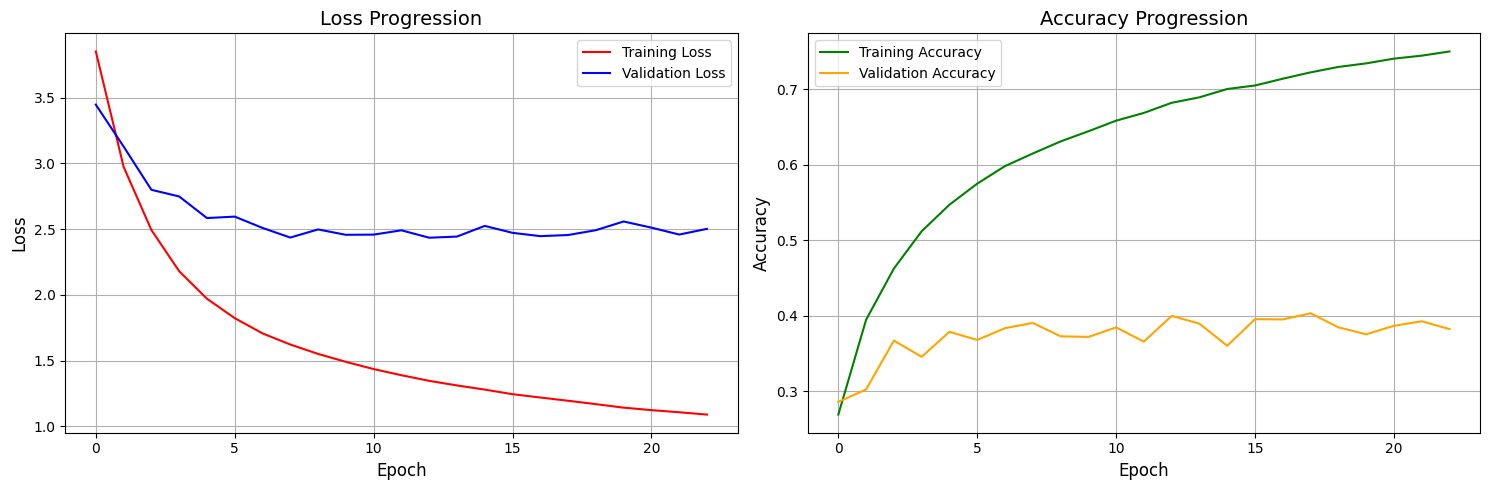

In [56]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [57]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7169 - loss: 1.2505 - weighted_accuracy: 0.7169
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4056 - loss: 2.4121 - weighted_accuracy: 0.4056


## **With Mel-Spectrogram, MFCCs, RMS**

In [58]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)

training_features.shape

(22631, 81, 87)

In [59]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)

validation_features.shape

(6044, 81, 87)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 81, 87)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 81, 32)              │           8,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 40, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 40, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 680,724 (2.60 MB)

 Trainable params: 680,724 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2188 - loss: 4.2173 - weighted_accuracy: 0.2188 - val_accuracy: 0.2760 - val_loss: 3.5073 - val_weighted_accuracy: 0.2760
Epoch 2/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3778 - loss: 3.1981 - weighted_accuracy: 0.3778 - val_accuracy: 0.3283 - val_loss: 3.1644 - val_weighted_accuracy: 0.3283
Epoch 3/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4533 - loss: 2.6561 - weighted_accuracy: 0.4533 - val_accuracy: 0.3489 - val_loss: 2.9155 - val_weighted_accuracy: 0.3489
Epoch 4/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5024 - loss: 2.3403 - weighted_accuracy: 0.5024 - val_accuracy: 0.3643 - val_loss: 2.7612 - val_weighted_accuracy: 0.3643
Epoch 5/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5501 - loss: 2.0993 - weighted_accuracy: 0.5501 - val_accuracy: 0.3590 - val_loss: 2.7315 - val_weighted_accuracy: 0.3590
Epoch 6/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - a

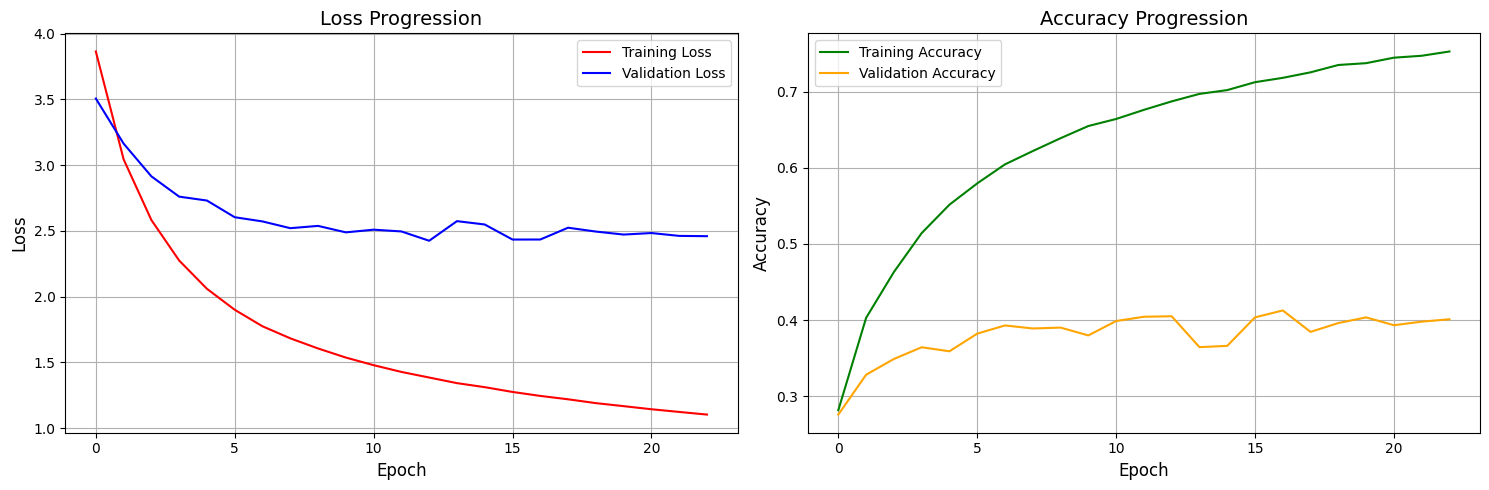

In [60]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [61]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_mfcc'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7238 - loss: 1.2845 - weighted_accuracy: 0.7238
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4101 - loss: 2.4065 - weighted_accuracy: 0.4101


## **With Mel-Spectrogram, MFCCs, Chroma**

In [62]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)

training_features.shape

(22631, 92, 87)

In [63]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)

validation_features.shape

(6044, 92, 87)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 92, 87)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 92, 32)              │           8,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         754,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 779,028 (2.97 MB)

 Trainable params: 779,028 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2156 - loss: 4.2164 - weighted_accuracy: 0.2156 - val_accuracy: 0.2725 - val_loss: 3.5352 - val_weighted_accuracy: 0.2725
Epoch 2/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3705 - loss: 3.2268 - weighted_accuracy: 0.3705 - val_accuracy: 0.2849 - val_loss: 3.2092 - val_weighted_accuracy: 0.2849
Epoch 3/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4372 - loss: 2.7393 - weighted_accuracy: 0.4372 - val_accuracy: 0.3468 - val_loss: 2.9909 - val_weighted_accuracy: 0.3468
Epoch 4/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4974 - loss: 2.3863 - weighted_accuracy: 0.4974 - val_accuracy: 0.3541 - val_loss: 2.8183 - val_weighted_accuracy: 0.3541
Epoch 5/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5427 - loss: 2.1347 - weighted_accuracy: 0.5427 - val_accuracy: 0.3880 - val_loss: 2.6704 - val_weighted_accuracy: 0.3880
Epoch 6/30
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - a

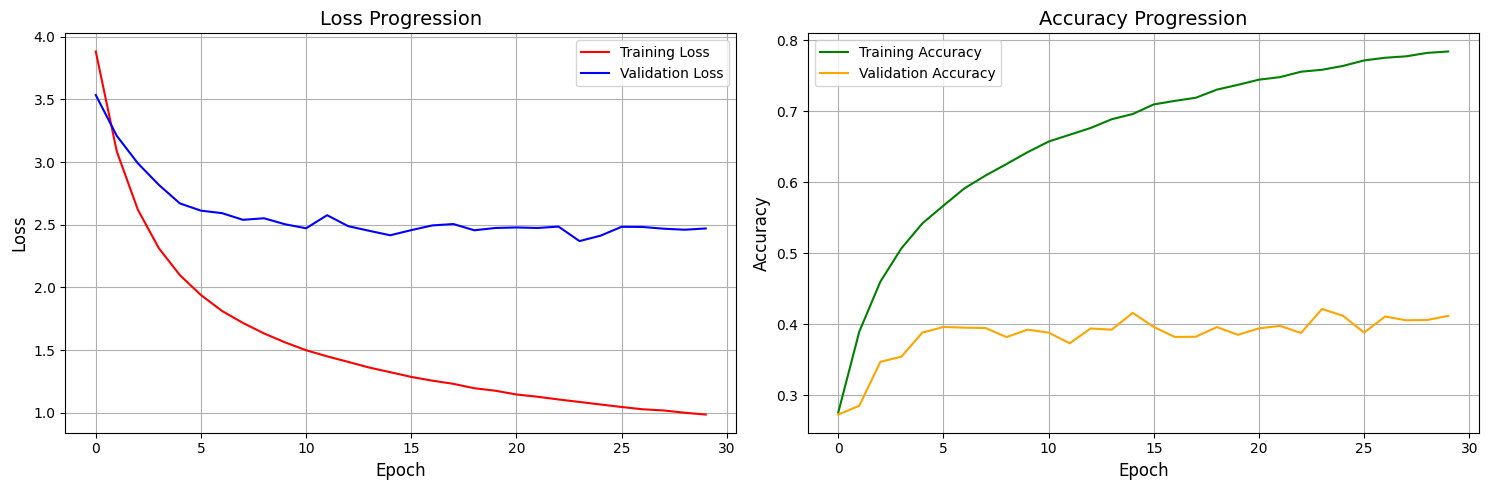

In [64]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [65]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7933 - loss: 0.9967 - weighted_accuracy: 0.7933
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4211 - loss: 2.3714 - weighted_accuracy: 0.4211


# Review results from all models

In [66]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.72,0.43
3,melspectrogram_chroma_mfcc,0.79,0.42
2,melspectrogram_rms_mfcc,0.72,0.41
1,mfcc_melspectrogram,0.72,0.40
